# Telco Churn Final Report

## Goals
* Discover account features that provide predictve value for customer churn
* Provide a model use in predicting which customers will likely churn
* Provide recomendations to stakeholders for reducing churn

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data
import scipy.stats as stats
import seaborn as sns
import numpy as np
import env
import os
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import acquire
import prepare
import explore

## Acquire

* Data acquired from the Codeup DB Server
* It contained 7043 rows and 25 columns before cleaning
* The data was aquired on 25 APR 2023
* Each row represents a unique Telco customer account
* Each column represents a feature of those accounts


## Prepare
* This step involved to iterations
* Iniitial preperation
    * Removed columns that did not contain useful information
    * Checked that column data types were appropriate
        * The total_charges column was modified from a string to a float
    * Chececked for null values
        * Null values in total_charges were replaced with a '0', because they represented new accounts that had been charged yet
    * Dummy columns were created for modeling
    * Renamed columns to promote readability
    * Outliers have not been removed for this iteration of the project
* Second iteration - post evaluation
    * Removed all feature columns that did not provide predictive value
    * Removed duplicated features 
    * Removed dummy columns that were not needed

### Data Dictionary

| Feature | Key | Data Type | Definition |
|---|---|---|---|
| customer_id | Unique ID | object | identifier for each individual customer's account |
| gender | Male/Female | object | Whether the client is a female or a male |
| senior_citizen | 1 = Yes 2 = No | int64 | Whether the client is a senior citizen or not |
| partner | Yes or No | object | Whether the client has a partner or not |
| dependents | Yes or No | object | Whether the client has dependents or not |
| tenure | Months | int64 | Number of months the customer has stayed with the company |
| phone_service | Yes or No | object | Whether the client has a phone service or not |
| multiple_lines | No phone service <br>No<br>Yes | object | Whether the client has multiple lines or not |
| online_security | 7043 non-null | object | Whether the client has online security or not |
| online_backup | 7043 non-null | object | Whether the client has online backup or not |
| device_protection | 7043 non-null | object | Whether the client has device protection or not |
| tech_support | No internet service<br>No<br>Yes | object | Whether the client has tech support or not |
| streaming_tv | No internet service<br>No<br>Yes | object | Whether the client has streaming TV or not |
| streaming_movies | No internet service<br>No<br>Yes | object | Whether the client has streaming movies or not |
| paperless_billing | Yes or No | object | Whether the client has paperless billing or not |
| monthly_charges | in USD | float64 | The amount charged to the customer monthly |
| total_charges | in USD | object | The total amount charged to the customer |
| churn (Target Feature) | Yes or No | object | Has the client churned or not |
| contract_type | Month-to-Month<br>One year<br>Two year | object | Indicates the customer’s current contract type |
| internet_service_type | DSL<br>Fiber optic<br>No | object | Whether the client is subscribed to Internet service with the company |
| payment_type | Electronic check<br>Mailed check<br>Bank transfer (automatic)<br>Credit Card (automatic) | object | The customer’s payment method |
|  |  |  |  |

### Bring in Data for Exploration

In [2]:
# Acquiring data
df = acquire.get_telco_data()
# Running initial preperation for exploration
df = prepare.prep_telco(df)
# Split
train, validate, test = prepare.split_data(df,'churn')

train -> (4225, 40), 59.99%
validate -> (1409, 40),20.01%
test -> (1409, 40), 20.01%


### Sneak Peak at the Data


In [3]:
train.head(3)

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_fiber_optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_electronic_check,payment_type_Mailed check
5911,5911,8319-QBEHW,Male,0,No,Yes,26,No,No phone service,No,...,0,1,0,1,0,0,0,0,0,0
2479,2479,3547-LQRIK,Female,0,Yes,No,47,Yes,Yes,No internet service,...,0,0,0,1,0,0,1,0,1,0
5889,5889,8280-MQRQN,Female,0,No,No,1,Yes,No,No,...,0,1,1,0,0,0,0,0,0,1


### Summary of Data

In [4]:
train.describe()

,Unnamed: 0,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,tech_support_No internet service,tech_support_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_fiber_optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_electronic_check,payment_type_Mailed check
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,...,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,3483.374911,0.161893,32.500828,65.056142,2298.513598,0.508639,0.488521,0.306272,0.218462,0.289467,...,0.395503,0.593846,0.265325,0.216095,0.235503,0.439053,0.218462,0.217515,0.336805,0.224852
std,2035.901018,0.368397,24.532563,30.268493,2271.603284,0.499985,0.499927,0.460999,0.413251,0.453569,...,0.489016,0.491172,0.441559,0.411628,0.424363,0.496330,0.413251,0.412604,0.472673,0.417534
min,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1695.000000,0.000000,9.000000,35.650000,411.600000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3476.000000,0.000000,29.000000,70.400000,1401.150000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5224.000000,0.000000,55.000000,90.150000,3865.450000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,7042.000000,1.000000,72.000000,118.750000,8672.450000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influenced your analysis
* Remember to split your data before exploring how different variables relate to one another
* Each question should be stated directly 
* Each question should be supported by a visualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two
* See the following example, and read the comments in the next cell

**The following empty code block** is here to represent the countless questions, visualizations, and statistical tests 
that did not make your final report. Data scientist often create a myriad of questions, visualizations 
and statistical tests that do not make it into the final notebook. This is okay and expected. Remember 
that shotgun approaches to your data such as using pair plots to look at the relationships of each feature 
are a great way to explore your data, but they have no place in your final report. 
**Your final report is about showing and supporting your findings, not showing the work you did to get there!**

### Do any of the demographic features provide relevant preditive value for churn?

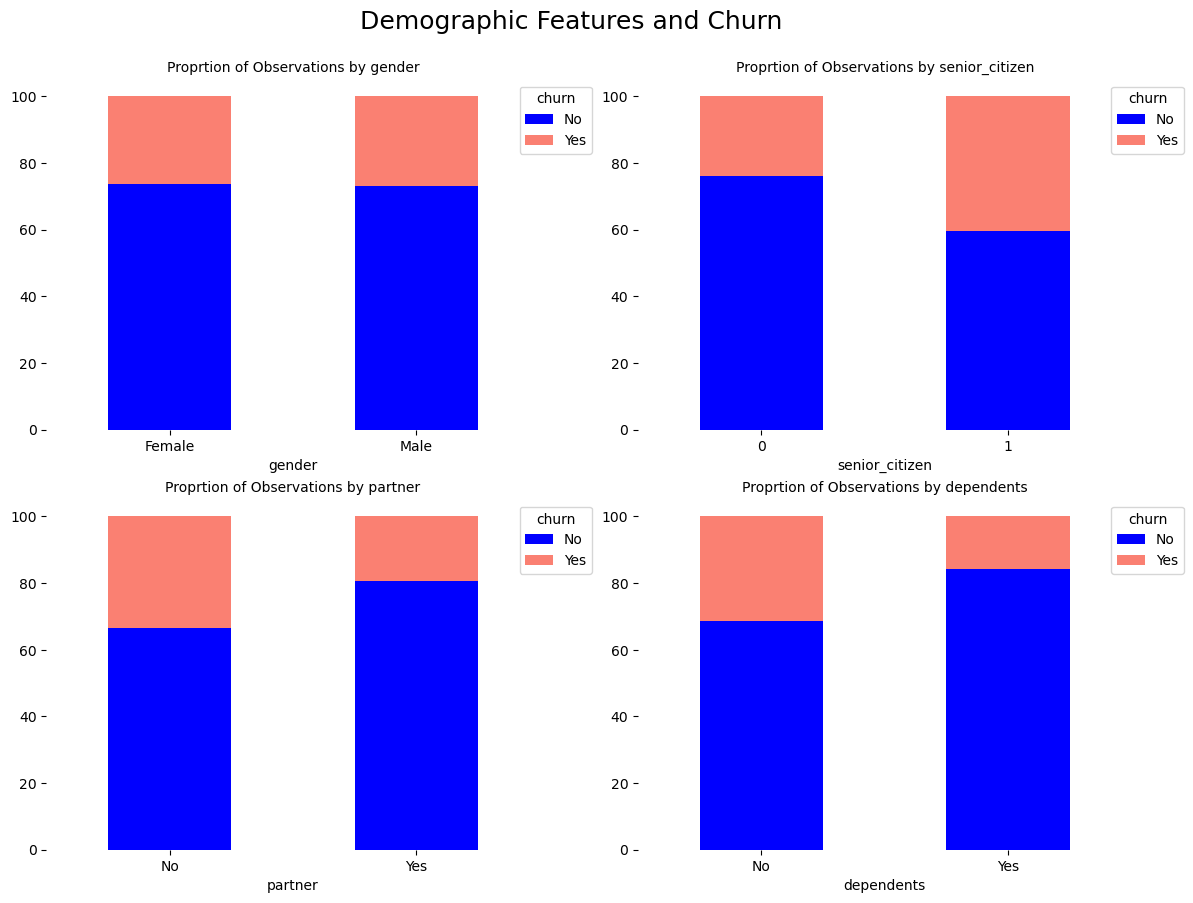

In [5]:
# Get visualizaions
explore.get_charts_demographics(train)

#### Charting Observations: Demographic Features
* gender appears to have no impact
* senior citizens appear to churn less
* however, they only make up 16.21% of observation making it an unreliable predictor over all

####  Statistics: Demographics
Lets use $\chi^2$ demographics: partner and dependents
* I will use a confidence interval of 95%
* The resulting alpha is .05

##### Hypothisis for partner (marital status)
$H_0$ : Churn is independent of marital status<br>
$H_a$ : Churn is dependent of marital status

In [6]:
# Running stat test
explore.get_partner_chi(train)

alpha = 0.05
chi^2 = 106.6312
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the partner.
 Therefore, we reject the Ho


##### Hypothisis for dependents
$H_0$ : Churn is independent on whether or not customers have dependents<br>
$H_a$ : Churn is dependent on whether or not customers have dependents

In [7]:
# Running stat test
explore.get_dependents_chi(train)

alpha = 0.05
chi^2 = 111.7405
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the dependents.
 Therefore, we reject the Ho


#### Result
Based on the results of the $\chi^2$ and the observation of the charts I belive te demographic features 'dependents' and 'partner' will have some positive impact on the model.

### Do catagorical customer account features provide relevant predictive value for churn?

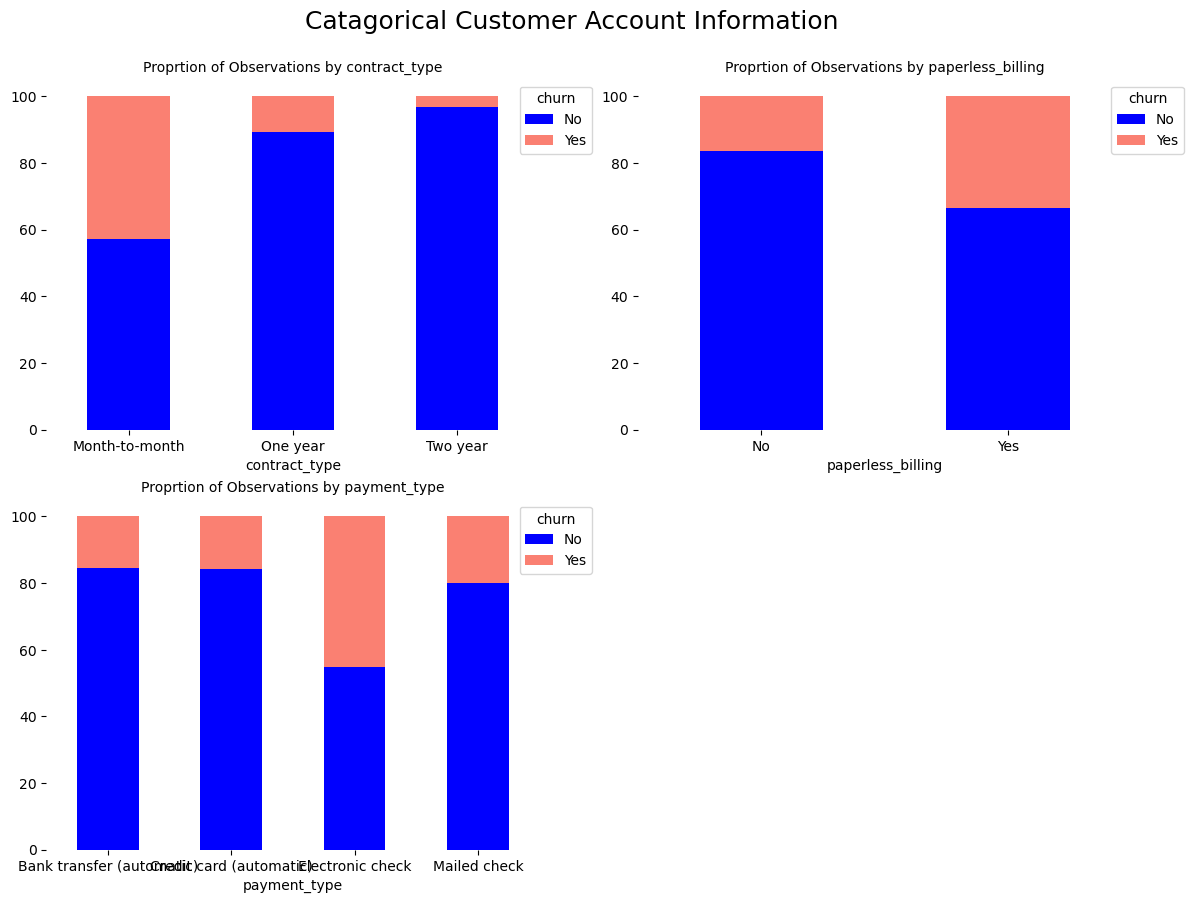

In [8]:
# Get visualizaions
explore.get_charts_cat_account(train)

#### Charting Observations: Catagorical Account Info
* Month-to-month contracts have higher churn rates compared to clients with yearly contracts
    * This makes since since the barrier to churn while on contract is high
    * This option is not likely to go away, but may be cause to promote contracts to M2M customers
* Customers with electronic check as paying method are more likely to leave the company
    * Other payment types are all the same
* Customers with paperless billing churn more often

#### Statistics: Catagorical Customer Account Information 
Lets use $\chi^2$ demographics: paperless_billing and payment_type_electronic_check
* I will use a confidence interval of 95%
* The resulting alpha is .05

##### Hypothisis for paperless_billing
$H_0$ : Churn is independent of paperless_billing<br>
$H_a$ : Churn is dependent of paperless_billing

In [9]:
# Running stat test
explore.get_paperless_billing_chi(train)

alpha = 0.05
chi^2 = 148.5845
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the paperless_billing.
 Therefore, we reject the Ho


##### Hypothisis for payment_type_electronic_check
$H_0$ : Churn is independent of payment_type_electronic_check<br>
$H_a$ : Churn is dependent of payment_type_electronic_check

In [10]:
# Running stat test
explore.get_payment_type_electronic_check_chi(train)         

alpha = 0.05
chi^2 = 381.5760
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the payment_type_electronic_check.
 Therefore, we reject the Ho


#### Result
* Based on the results of the $\chi^2$ and the observation of the charts I belive te demographic features 'paperless_billing' and 'payment_type_electronic_check' will have some positive impact on the model.

### Do numerical customer account features provide relevant predictive value for churn?

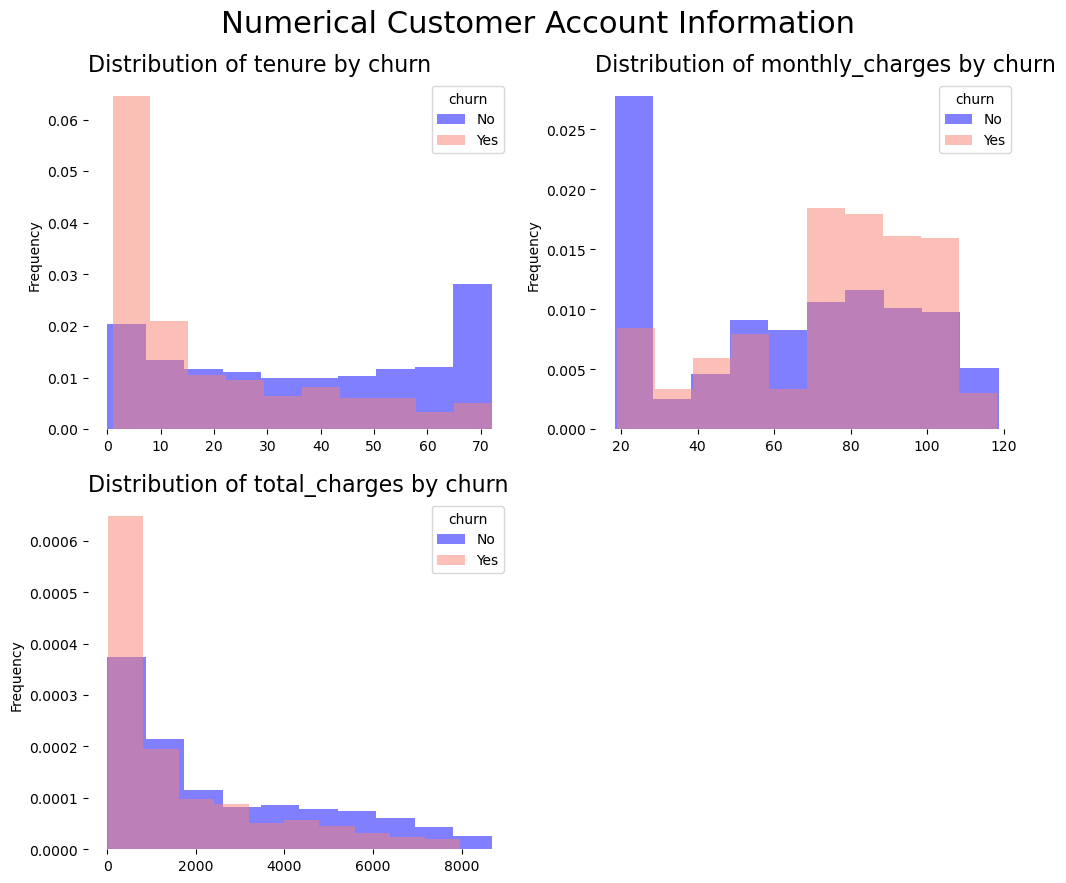

In [11]:
# Get visualizaions
explore.get_charts_num_account(train)

#### Chart Observations: Numerical Customer Account Information
* High monthly charges appear to lead to higher churn rates
* New customers appera to churn faster than long term customers
* High total charges appear to have lower churn rates
    * this is likely due to tenure of these customers more so than the higher charges 
    * total_charges is also a result of customer tenure, so we can ignore this feature

#### Statistics: Numerical Customer Account Information
Lets do some T-stats for the remaining demographics: tenure and monthly charges
* I will use a confidence interval of 95%
* The resulting alpha is .05

##### Hypothisis for tenure
Churn is catagorical, and tenure is a continuous number features so lets do a One Sample T-Test<br>
$H_0$ : The mean tenure of churned customers is = the mean tenure of all churned customers<br>
$H_a$ : The mean tenure of churned customers is != the mean tenure of all churned customers

In [12]:
# Running t-stat test
explore.get_tenure_tstat(train)

t-score = -24.280881230430392, p-value = 5.680256511980203e-105
Since the p-value is not equal to alpha, we reject Null Hypothisis
 There is a significant relationship between churn and tenure 


##### Hypothisis for monthly_charges
Churn is catagorical, and tenure is a continuous number features so lets do a One Sample T-Test <br>
$H_0$ : Mean of monthly charges of churned customers <= Mean of monthly charges of all customers<br>
$H_a$ : Mean of monthly charges of churned customers > Mean of monthly charges of all customers

In [13]:
# Running t-stat test
explore.get_monthly_charges_ttest(train)

t=12.65294490503547, p/2 = 1.0740986591134452e-34
Since p/2 > alpha and t < 0 We reject Null Hypothisis
  There is a significant relationship between churn and monthly_charges


#### Result
* Based on the results from the One Sample T-Test's and the charts, I belive numerical customer account features 'tenure' and 'monthly_charges' will have some positive effect on the model

### Do any of the service features provide relevant predictive value for churn? 

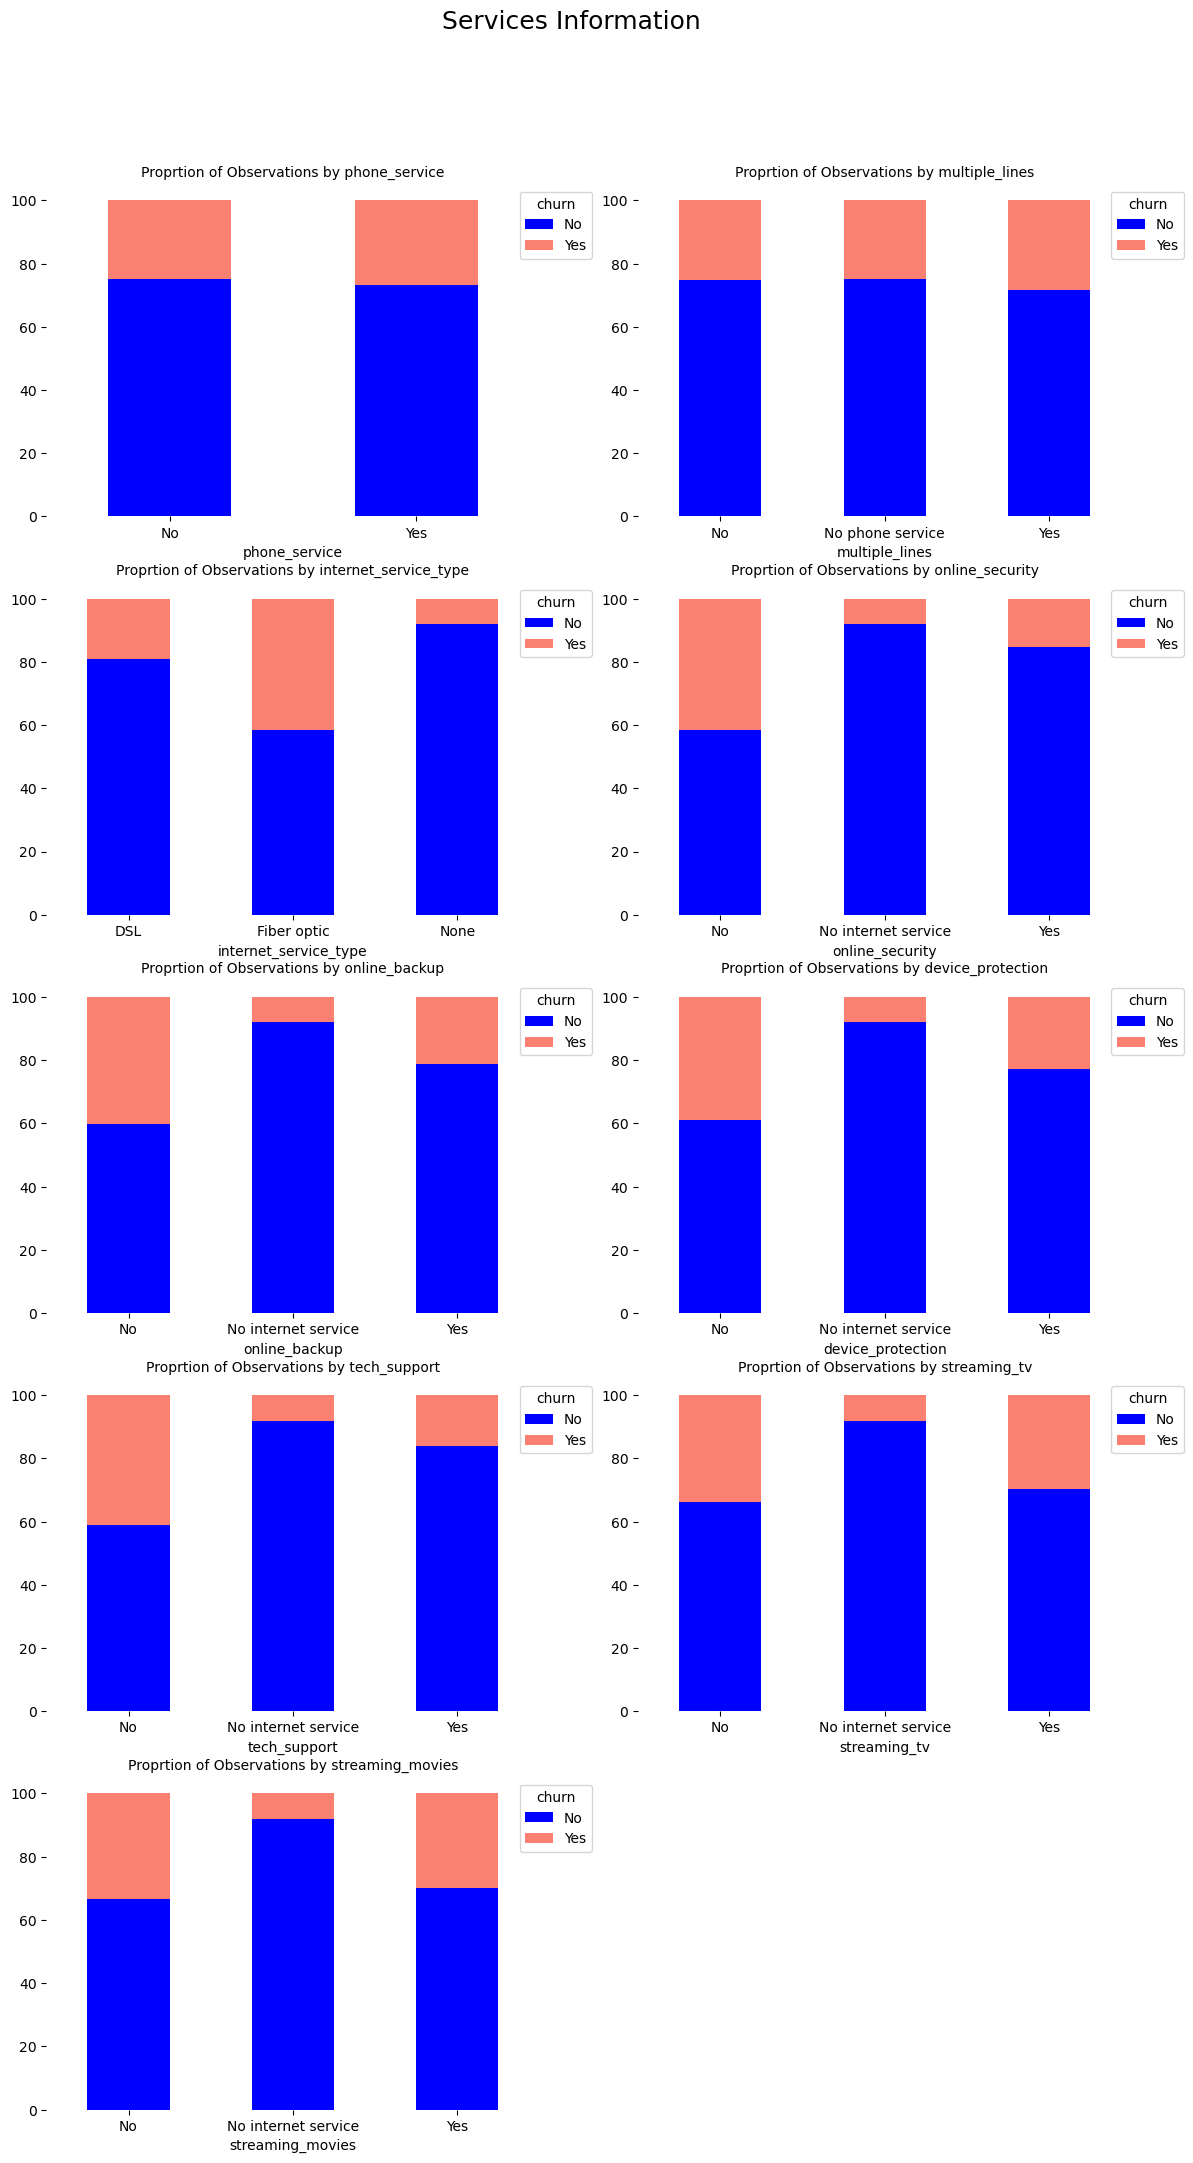

In [14]:
# Get visualizaions
explore.get_charts_services(train)

#### Chart Observations: Service Information
* phone related features seem to have no real predictive value for churn rates
* Not having tech support seems to indicate higher churn rates
* Fiber optic customers apperar to churn at a higher rate
* The other features appear to have a similar minimal impact on churn rates 
    * these features all have similar effects, perhaps they all come together
    * so I will ignore them for now

####  Statistics: Demographics
Lets use $\chi^2$ demographics: internet_service_type_fiber_optic and tech_support_Yes
* I will use a confidence interval of 95%
* The resulting alpha is .05

#### Hypothisis for tech_support_Yes
$H_0$ : Churn is independent of tech_support_Yes<br>
$H_a$ : Churn is dependent of tech_support_Yes

In [15]:
# Running stat test
explore.get_tech_support_Yes_chi(train)

alpha = 0.05
chi^2 = 98.2309
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the tech_support_Yes.
 Therefore, we reject the Ho


#### Hypothisis for internet_service_type_fiber_optic
$H_0$ : Churn is independent of internet_service_type_fiber_optic<br>
$H_a$ : Churn is dependent of internet_service_type_fiber_optic

In [16]:
# Running stat test
explore.get_internet_service_type_fiber_optic_chi(train)

alpha = 0.05
chi^2 = 387.4117
p-value = 0.0000
Since the p-value is less than alpha, there exists some relationship between churn and the internet_service_type_fiber_optic.
 Therefore, we reject the Ho


#### Result
* Based on the results of the $\chi^2$ and the observation of the charts I belive te demographic features 'internet_service_type_fiber_optic' and 'tech_support_Yes' will have some positive impact on the model.

## Exploration Summary
* After your explore section, before you start modeling, provide a summary of your findings in Explore
* Include a summary of your take-aways
* Include a summary of the features you examined and weather or not you will be going to Modeling with each feature and why
* It is important to note which features will be going into your model so the reader knows what features you are using to model on

## You may use this as a template for how to ask and answer each question:

### 1) Question about the data
* Ask a question about the data for which you got a meaningful result
* There is no connection can be a meaningful result

### 2) Visualization of the data answering the question

* Visualizations should be accompanied by take-aways telling the reader exactly what you want them to get from the chart
* You can include theses as bullet points under the chart
* Use your chart title to provide the main take-away from each visualization
* Each visualization should answer one, and only one, of the explore questions

### 3) Statistical test
* Be sure you are using the correct statistical test for the type of variables you are testing
* Be sure that you are not violating any of the assumptions for the statistical test you are choosing
* Your notebook should run and produce the results of the test you are using (This may be done through imports)
* Include an introduction to the kind of test you are doing
* Include the Ho and Ha for the test
* Include the alpha you are using
* Include the readout of the p-value for the test
* Interpret the results of the test in natural language (I reject the null hypothesis is not sufficient)

### 4) Answer to the question
* Answer the question you posed of the data by referring to the chart and statistical test (if you used one)
* If the question relates to drivers, explain why the feature in question would/wouldn't make a good driver

## Modeling

### Introduction
* Explain how you will be evaluating your models
* Include the evaluation metric you will be using and why you have chosen it
* Create a baseline and briefly explain how it was calculated 

In [17]:
# If you use code to generate your baseline run the code and generate the output here

Printout should read: <br>
Baseline: "number" "evaluation metric"

### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

## You may use this as a template for how to introduce your models:

### Model Type

In [18]:
# Code that runs the best model in that model type goes here 
# (This may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on train: "evaluation result" <br>
"evaluation metric" on validate: "evaluation result"

### Test Model
* Choose the best model out of the three as you best model and explain why you have chosen it
* Explain that you will now run your final model on test data to gauge how it will perform on unseen data

In [19]:
# Code that runs the best overall model on test data (this may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

### Summery
* Summarize your findings and answer the questions you brought up in explore 
* Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**